/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


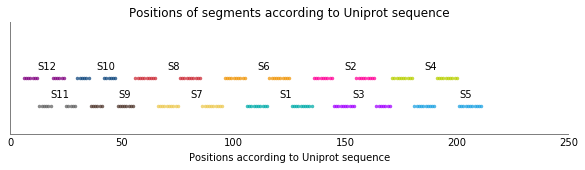

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


In [1]:
%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks17'
image_counter = Counter()

### Lucas files

In [2]:
species_distances = pd.read_csv(files_dump_folder + 'evolutionary_distance_vs_weights/' + 'HIS3_alignment_500species.fas.tab.pairwise.proportion.txt',)
alignment_569sp = pd.read_table(files_dump_folder + 'evolutionary_distance_vs_weights/' + 'HIS3_alignment_500species.fas.tsv')
alignment_569sp.set_index('organism', inplace=True)

Scer_name = 'sp|P06633|HIS7_YEAST_Imidazoleglycerol-phosphate_dehydratase_OSSaccharomyces_cerevisiae_(strain_ATCC_204508_/_S288c)_GNHIS3_PE1_SV2'
Scer_aligned_seq = alignment_569sp.loc[Scer_name].aligned_seq

In [3]:
def remove_gaps(seq):
    return ''.join([c for c in seq if c != '-'])

In [4]:
Scer_name_distances = 'sp|P06633|HIS7 YEAST Imidazoleglycerol-phosphate dehydratase OSSaccharomyces cerevisiae (strain ATCC 204508 / S288c) GNHIS3 PE1 SV2'

def figure_other_organism(df):
    if df['organism1'] == Scer_name_distances:
        return df['organism2']
    elif df['organism2'] == Scer_name_distances:
        return df['organism1']
    else:
        return None

Scer_distances = species_distances[(species_distances['organism1'] == Scer_name_distances) | \
                                   (species_distances['organism2'] == Scer_name_distances)].copy()

Scer_distances['other_organism'] = Scer_distances.apply(figure_other_organism, axis=1)
assert len(Scer_distances[Scer_distances['other_organism'] == Scer_name_distances]) == 0
Scer_distances[:2]

,organism1,organism2,distance,other_organism
87571,sp|Q9S5G5|HIS7 ECO57 Histidine biosynthesis bi...,sp|P06633|HIS7 YEAST Imidazoleglycerol-phospha...,0.545,sp|Q9S5G5|HIS7 ECO57 Histidine biosynthesis bi...
87572,sp|P06987|HIS7 ECOLI Histidine biosynthesis bi...,sp|P06633|HIS7 YEAST Imidazoleglycerol-phospha...,0.545,sp|P06987|HIS7 ECOLI Histidine biosynthesis bi...


In [5]:
all_natural_unique_single_mutations = sorted(list(set(flatten_list(natural_unique_single_mutations.values()))), key=lambda s: int(s[:-1]))
all_natural_unique_single_mutations = [get_full_mutation(m) for m in all_natural_unique_single_mutations]

Check this function


In [6]:
def get_position_in_alignment(aligned_seq, position_in_Scer_Uniprot):
    counter = 0
    for index, aa in enumerate(aligned_seq):
        if aa != '-' :
            counter += 1
        if counter == position_in_Scer_Uniprot+1:
            break
    try: 
        assert Scer_aligned_seq[index] == Scer_Uniprot[position_in_Scer_Uniprot]
    except:
        print 'Position in Uniprot:', position_in_Scer_Uniprot
        print 'Position in alignment:', index
        print 'Char in aligned Scer seq:', Scer_aligned_seq[index]
        print 'Char in Uniprot Scer seq:', Scer_Uniprot[position_in_Scer_Uniprot]

        print 'Char in aligned Scer seq:', Scer_aligned_seq[:index]
        print 'Char in Uniprot Scer seq:', Scer_Uniprot[:position_in_Scer_Uniprot]
        assert Scer_aligned_seq[index] == Scer_Uniprot[position_in_Scer_Uniprot]
    return index

evolutionary_distances = OrderedDict()
for mutation in all_natural_unique_single_mutations:
    position_Scer = int(mutation[1:-1])-1
    position_in_alignment = get_position_in_alignment(Scer_aligned_seq, position_Scer)
    Scer_distances['aa_state'] = Scer_distances['other_organism'].apply(
        lambda s: alignment_569sp.loc['_'.join(s.split())]['aligned_seq'][position_in_alignment])
    distance_values = [Scer_distances[Scer_distances['aa_state'] == mutation[-1]]['distance'].values]

    if len(distance_values[0]) == 0:
        print mutation, position_Scer, position_in_alignment
        print Scer_aligned_seq[position_in_alignment], Scer_Uniprot[position_Scer]
        print distance_values
        print
        break
    evolutionary_distances[mutation] = distance_values

### Weights

In [7]:
# Relative >>> absolute position
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_short, relative_position):
    return int(position_translation.iloc[int(relative_position)][segment_short])

In [8]:
weights_folder = os.path.join(analysis_folder, 'Katya', 'NN', 'weights', '')
weights = OrderedDict()
for segment in data:
    weights[segment] = pd.read_csv(weights_folder + '%s.csv' %segment.split('_')[0])
    print weights[segment]['Unnamed: 0'].values
    weights[segment]['mut_list_Scer'] = weights[segment]['Unnamed: 0'].apply(lambda s: 
                                                                             str(get_absolute_position(segment.split('_')[0], int(s[:1]))) + s[1:])
    weights[segment].set_index('mut_list_Scer', inplace=True)

mutations_weights = OrderedDict()
for mutation in all_natural_unique_single_mutations:
    print mutation
    for segment in weights:
        try:
            weight = weights[segment].loc[mutation[1:]].weight
            mutations_weights[mutation] = weight
            print weight
            print
        except KeyError:
            pass
print len(mutations_weights)

['0D' '0E' '0K' '0N' '10R' '11F' '12G' '13S' '14G' '15F' '16A' '17P' '18L'
 '19D' '1A' '20E' '21A' '22L' '23S' '24R' '25A' '25S' '26V' '27V' '28D'
 '29F' '29L' '2I' '2L' '2M' '2V' '3G' '4A' '4D' '4E' '4H' '4K' '4N' '4P'
 '4Q' '4T' '5F' '5I' '5V' '6K' '6R' '6T' '7G' '8I' '8L' '8V' '9A' '9E' '9K'
 '9T']
['0S' '10G' '11L' '12Q' '13R' '14E' '15K' '16V' '17G' '18D' '19L' '1D' '1G'
 '1N' '1S' '20S' '21C' '21S' '21T' '22E' '23M' '24I' '24V' '25P' '25T'
 '26H' '27F' '27I' '27L' '27V' '2R' '3A' '3P' '4F' '4Y' '5A' '5C' '5S' '6F'
 '6V' '7I' '7T' '7V' '8D' '8E' '8K' '8N' '9L']
['0I' '0L' '10L' '11S' '12C' '13E' '14M' '15I' '16P' '17H' '18F' '19I'
 '19L' '19M' '1G' '20D' '20E' '20H' '20Q' '21S' '22F' '23A' '23S' '24E'
 '24G' '24Q' '24R' '25A' '25G' '25S' '25T' '2F' '2L' '3K' '3Q' '3R' '4R'
 '5E' '6K' '6M' '7I' '7V' '8G' '9D' '9E' '9Q']
['0A' '0S' '10R' '11G' '12K' '13N' '14D' '15H' '16H' '17R' '18S' '19E' '1A'
 '1G' '1R' '1S' '20S' '21A' '22F' '23K' '24A' '24S' '25F' '25L' '26A' '27I'
 '27L' '27V'

In [9]:
for segment in weights:
    if 'A170T' in weights[segment].index:
        print segment

In [10]:
weights['S7_scaled'].index

Index([u'66F', u'66I', u'66L', u'66Y', u'670S', u'671L', u'672I', u'673V',
       u'674E', u'675C', u'676I', u'677G', u'678D', u'679L', u'67H', u'67N',
       u'67T', u'680D', u'680F', u'680H', u'680V', u'680Y', u'681I', u'681V',
       u'682D', u'683D', u'684H', u'685H', u'686S', u'686T', u'687A', u'687I',
       u'687L', u'687S', u'687T', u'687V', u'688E', u'689D', u'68A', u'69L',
       u'70A', u'71K', u'72H', u'73A', u'73G', u'73S', u'74G', u'75W'],
      dtype='object', name=u'mut_list_Scer')

In [11]:
for segment in weights:
    display(weights[segment])

,Unnamed: 0,weight
mut_list_Scer,,
106D,0D,0.909814
106E,0E,-1.538786
106K,0K,-1.029825
106N,0N,0.713743
1070R,10R,0.354708
1071F,11F,0.058143
1072G,12G,-0.385277
1073S,13S,0.005796
1074G,14G,0.297664


,Unnamed: 0,weight
mut_list_Scer,,
136S,0S,-0.399324
1370G,10G,-0.164988
1371L,11L,-0.031906
1372Q,12Q,-0.406036
1373R,13R,-0.214394
1374E,14E,-0.013934
1375K,15K,-0.031790
1376V,16V,0.047545
1377G,17G,0.095524


,Unnamed: 0,weight
mut_list_Scer,,
145I,0I,1.185339
145L,0L,-0.682080
1460L,10L,0.062814
1461S,11S,-0.094857
1462C,12C,0.087407
1463E,13E,0.008635
1464M,14M,-0.459644
1465I,15I,-0.105773
1466P,16P,0.130431


,Unnamed: 0,weight
mut_list_Scer,,
171A,0A,-1.046315
171S,0S,1.289027
1720R,10R,0.042768
1721G,11G,0.105227
1722K,12K,0.204841
1723N,13N,0.146738
1724D,14D,0.014316
1725H,15H,-0.267983
1726H,16H,-0.234246


,Unnamed: 0,weight
mut_list_Scer,,
181H,0H,1.343669
181R,0R,-2.404886
181Y,0Y,-0.797512
1820S,10S,0.059458
1821A,11A,-0.075804
1822F,12F,0.019576
1823K,13K,-0.047179
1824A,14A,0.045694
1825L,15L,0.146309


,Unnamed: 0,weight
mut_list_Scer,,
96C,0C,-3.812409
96S,0S,2.642344
96T,0T,-2.554463
970E,10E,-0.203796
971A,11A,-0.044682
972L,12L,0.321893
973G,13G,-0.281425
974A,14A,-0.215792
975V,15V,0.181833


,Unnamed: 0,weight
mut_list_Scer,,
66F,0F,0.253026
66I,0I,-4.338084
66L,0L,-4.696863
66Y,0Y,4.001598
670S,10S,-0.309580
671L,11L,-0.054847
672I,12I,0.167804
673V,13V,0.276630
674E,14E,0.110443


,Unnamed: 0,weight
mut_list_Scer,,
56D,0D,-0.580281
56E,0E,0.589960
56H,0H,-0.665499
56Q,0Q,-0.472164
570I,10I,0.373404
571H,11H,0.204914
572A,12A,0.402298
573L,13L,0.226341
574A,14A,0.081481


,Unnamed: 0,weight
mut_list_Scer,,
36P,0P,-0.273668
36Q,0Q,-0.097588
370Q,10Q,0.574878
371A,11A,0.549255
372S,12S,-0.041564
372T,12T,-0.528696
373G,13G,-0.071671
373Q,13Q,0.298895
374G,14G,-0.834924


,Unnamed: 0,weight
mut_list_Scer,,
30I,0I,-6.812658
30L,0L,-4.564171
30P,0P,-2.619537
30T,0T,-3.982607
310A,10A,2.851051
311E,11E,2.674421
312A,12A,-0.791049
312D,12D,-0.579938
313H,13H,0.039407


,Unnamed: 0,weight
mut_list_Scer,,
13H,0H,0.301144
13K,0K,-0.906387
13N,0N,-0.642666
13Q,0Q,-0.140531
140L,10L,-0.072021
141K,11K,0.186380
142E,12E,2.922259
142G,12G,-3.307419
142K,12K,1.523552


,Unnamed: 0,weight
mut_list_Scer,,
6A,0A,0.403431
70K,10K,0.559690
71I,11I,0.117974
72Q,12Q,0.311233
73I,13I,0.471759
73V,13V,-0.455733
74A,14A,-1.947137
74S,14S,0.810265
75I,15I,0.205013


### Merging

In [12]:
evol_dist = pd.DataFrame.from_dict(evolutionary_distances, orient='index')
evol_dist.columns = ['distances']
neural_weights = pd.DataFrame.from_dict(mutations_weights, orient='index')
merged = evol_dist.merge(neural_weights, how='inner', left_index=True, right_index=True)
# merged.drop('Unnamed: 0', inplace=True, axis=1)
merged['dist_min'] = merged['distances'].apply(np.min)
merged['dist_mean'] = merged['distances'].apply(np.mean)
merged['dist_median'] = merged['distances'].apply(np.median)
merged

,distances,0,dist_min,dist_mean,dist_median
L7F,"[0.554, 0.191, 0.186, 0.26, 0.178, 0.155, 0.21...",-0.890599,0.155,0.310750,0.2585
L7S,"[0.595, 0.589, 0.581, 0.577, 0.538, 0.564, 0.5...",0.102242,0.367,0.561525,0.5680
V8I,"[0.576, 0.582, 0.552, 0.552, 0.552, 0.552, 0.5...",-1.361010,0.127,0.542107,0.5570
V8F,"[0.552, 0.345, 0.621, 0.393]",0.511287,0.345,0.477750,0.4725
K9N,"[0.56, 0.56, 0.561, 0.561, 0.56, 0.527, 0.561,...",-0.130750,0.127,0.472750,0.5600
K9S,"[0.571, 0.582, 0.587, 0.56, 0.191, 0.559, 0.55...",-0.756403,0.155,0.525542,0.5630
K9R,"[0.583, 0.585, 0.583, 0.572, 0.597, 0.556, 0.5...",-1.643202,0.263,0.535267,0.5720
I11D,"[0.554, 0.24, 0.538, 0.574, 0.538, 0.549, 0.57...",-0.221479,0.240,0.489000,0.5465
I11N,"[0.545, 0.545, 0.545, 0.545, 0.544, 0.545, 0.5...",-0.724171,0.186,0.555842,0.5640
I11V,"[0.561, 0.56, 0.56, 0.585, 0.552, 0.559, 0.26,...",-1.669559,0.260,0.550121,0.5610


AttributeError: 'DataFrame' object has no attribute 'weight'

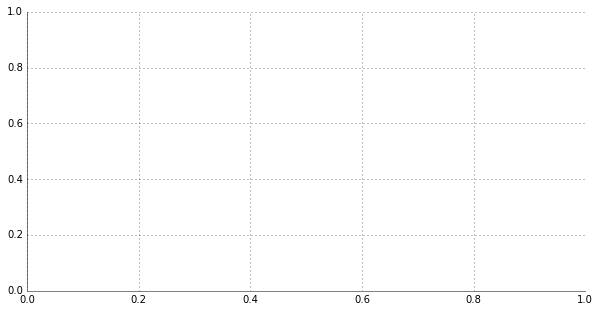

In [13]:
plot_better()
plt.scatter(merged.dist_min, merged.weight, edgecolor='none', alpha=0.6, color='red')
statistics = stats.spearmanr(merged.dist_min, merged.weight)
plt.xlabel('Minimal evolutionary distance to aa state', fontsize=12)
plt.ylabel('Weight of a state in neural network data', fontsize=12)
plt.title('Evolution vs. neural network' + '\nSpearman coeff: %.2f, p-value=%.5f' %(statistics[0], statistics[1]))